In [1]:
# External
import mne
import numpy as np

# Python API
import sys
import json

# Local
from double_dipper import constants
from double_dipper.io import filePairs, partition

In [7]:
def labeller(metadata):
    if metadata["darkening"] != True: return None
    if metadata["tone"] == True:      return 1
    else:                             return 0

In [8]:
subjects = [1, 2, 3, 4, 6, 7, 8 , 9, 10, 11]
pairs = filePairs(*[f"cleaned/main/{subjNo}" for subjNo in subjects])
dataset = partition(lambda meta: 0, labeller, pairs)
dataset = dataset[0]

X = dataset["x"]
Y = dataset["y"]

withTone = X[Y == 1]
withoutTone = X[Y == 0]

In [9]:
sfreq = constants.sfreq
channel_names = constants.channel_names
info = mne.create_info(channel_names, sfreq, ch_types=["eeg"]*len(channel_names))

In [10]:
darkening = constants.darkening
problem = constants.problem
strategy_prompt = constants.strategy_prompt
tone = constants.tone

In [11]:
events = sorted([darkening, problem, strategy_prompt, tone], key=lambda e: e.delay)
events = np.stack([e.occurrence for e in events])

## Darkening Preceded by Tone

In [12]:
def quickPlot(data, event_id, start, duration):
    %matplotlib notebook
    mne.viz.plot_raw(data, events,
                 highpass=1, lowpass=32,
                 event_color={
                    problem.code: "b",
                    darkening.code: "k",
                    strategy_prompt.code: "y",
                    tone.code: "r"
                },
                 event_id=event_id,
                 start=start, duration=duration,
    );

Creating RawArray with float64 data, n_channels=4, n_times=5632
    Range : 0 ... 5631 =      0.000 ...    21.996 secs
Ready.
Setting up band-pass filter from 1 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 32.00 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


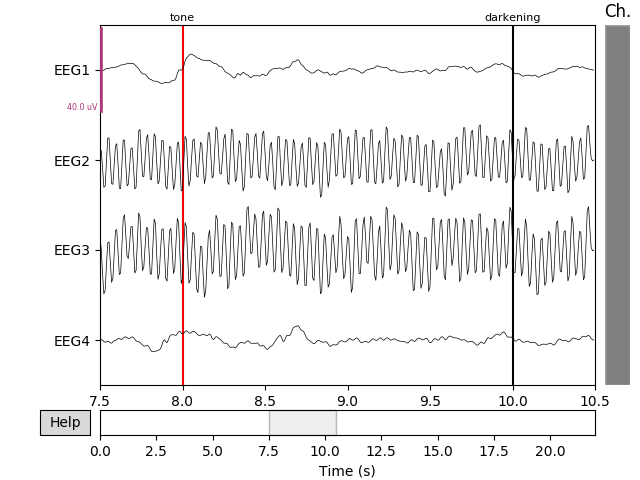

In [13]:
event_id = {
    "darkening": darkening.code, "problem": problem.code, "prompt": strategy_prompt.code, "tone": tone.code
}
meanWithTone = np.mean(withTone, axis=0)
meanWithTone = mne.io.RawArray(meanWithTone, info)
quickPlot(meanWithTone, event_id, tone.delay - 0.5, darkening.delay - tone.delay + 1)

Setting up band-pass filter from 1 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 32.00 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


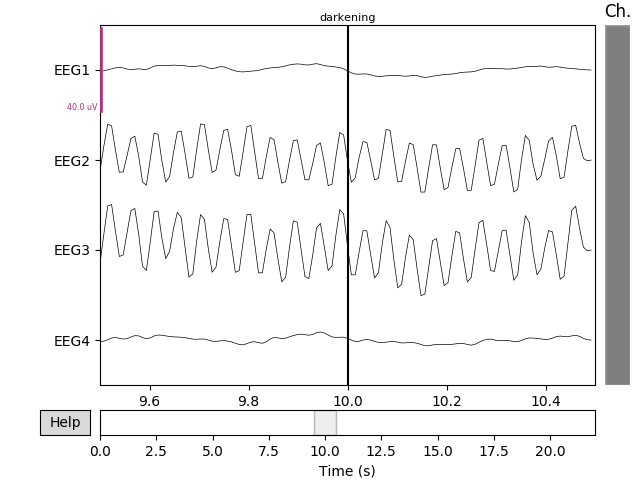

In [14]:
quickPlot(meanWithTone, event_id, darkening.delay - 0.5, 1)

## Darkening not Preceded by Tone

Creating RawArray with float64 data, n_channels=4, n_times=5632
    Range : 0 ... 5631 =      0.000 ...    21.996 secs
Ready.
Setting up band-pass filter from 1 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 32.00 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


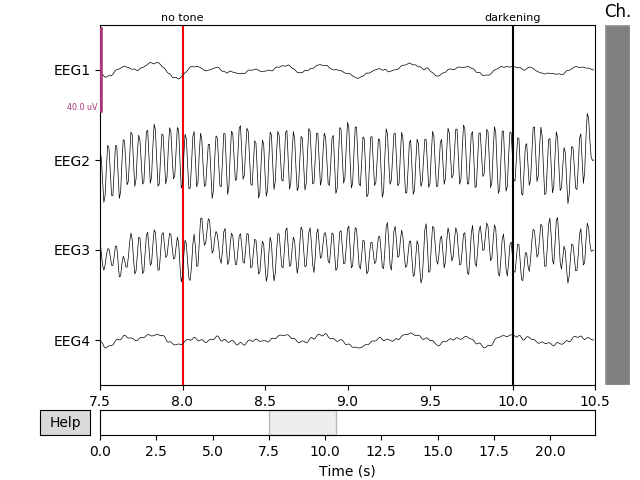

In [15]:
event_id = {
    "darkening": darkening.code,
    "problem": problem.code,
    "prompt": strategy_prompt.code,
    "no tone": tone.code
}
meanWithoutTone = np.mean(withoutTone, axis=0)
meanWithoutTone = mne.io.RawArray(meanWithoutTone, info)
quickPlot(meanWithoutTone, event_id, tone.delay - 0.5, darkening.delay - tone.delay + 1)

Setting up band-pass filter from 1 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 32.00 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


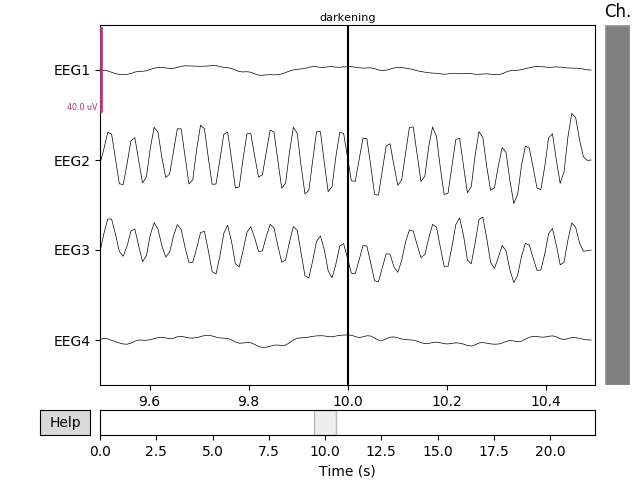

In [16]:
quickPlot(meanWithoutTone, event_id, darkening.delay - 0.5, 1)

## Binary Classification

In [21]:
X = mne.filter.filter_data(data, sfreq, l_freq=1, h_freq=32)
X = X.reshape([X.shape[0], np.prod(X.shape[1:])])

Setting up band-pass filter from 1 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 845 samples (3.301 sec)



In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
model.fit(data, labels)

/home/elmines/git/DoubleDipperAnalysis/env/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [23]:
preds = model.predict(data)

In [24]:
from sklearn.metrics import precision_recall_fscore_support
(precision,recall, f1, _) = precision_recall_fscore_support(labels, preds, average="binary")
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {f1}")

precision = 0.8916967509025271
recall = 0.8821428571428571
f1 = 0.8868940754039497
